In [1]:
#### boolq for moe

In [2]:
import torch
import datasets
import transformers
datasets.logging.set_verbosity_error()
transformers.logging.set_verbosity_error()

from transformers import (AutoTokenizer, AutoModelForSequenceClassification, default_data_collator, AdamW, 
                          get_linear_schedule_with_warmup)

from MoE import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using transformers v{transformers.__version__} and datasets v{datasets.__version__}")
print(f"Running on device: {device}")

Using transformers v4.44.0.dev0 and datasets v2.20.0
Running on device: cuda


In [3]:
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [4]:
#### dataset
from datasets import load_dataset

boolq = load_dataset("super_glue", "boolq")
boolq

DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3245
    })
})

In [5]:
### tokenizer
from transformers import AutoTokenizer

bert_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)

def tokenize_and_encode(examples): 
    return tokenizer(examples['question'], examples['passage'], truncation="only_second")

boolq_enc = boolq.map(tokenize_and_encode, batched=True)

train_ds = boolq_enc["train"]
eval_ds = boolq_enc["validation"]

In [6]:
###### training_args & trainer
from transformers import TrainingArguments, Trainer

class PruningTrainingArguments(TrainingArguments):
    def __init__(self, *args, initial_threshold=1., final_threshold=0.1, initial_warmup=1, final_warmup=2, final_lambda=0.,
                 mask_scores_learning_rate=0., **kwargs): 
        super().__init__(*args, **kwargs)

        self.initial_threshold = initial_threshold
        self.final_threshold = final_threshold
        self.initial_warmup = initial_warmup
        self.final_warmup = final_warmup
        self.final_lambda = final_lambda
        self.mask_scores_learning_rate = mask_scores_learning_rate

In [7]:
### decide the training parameters

class PruningTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        if self.args.max_steps > 0:
            self.t_total = self.args.max_steps
            self.args.num_train_epochs = self.args.max_steps // (len(self.get_train_dataloader()) // self.args.gradient_accumulation_steps) + 1
        else:
            self.t_total = len(self.get_train_dataloader()) // self.args.gradient_accumulation_steps * self.args.num_train_epochs
            
        
    def create_optimizer_and_scheduler(self, num_training_steps: int):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if "mask_score" in n and p.requires_grad],
                "lr": self.args.mask_scores_learning_rate,
            },
            {
                "params": [
                    p
                    for n, p in self.model.named_parameters()
                    if "mask_score" not in n and p.requires_grad and not any(nd in n for nd in no_decay)
                ],
                "lr": self.args.learning_rate,
                "weight_decay": self.args.weight_decay,
            },
            {
                "params": [
                    p
                    for n, p in self.model.named_parameters()
                    if "mask_score" not in n and p.requires_grad and any(nd in n for nd in no_decay)
                ],
                "lr": self.args.learning_rate,
                "weight_decay": 0.0,
            },
        ]
        
        for group in optimizer_grouped_parameters:
            print(f"Group with lr {group['lr']}:")
            for param in group['params']:
                print(f"  - {param.shape}")
                
        self.optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=self.args.adam_epsilon)
        self.lr_scheduler = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=self.t_total
        )
        
        
    def compute_loss(self, model, inputs, return_outputs=False):
            
        threshold, regu_lambda = self._schedule_threshold(
            step=self.state.global_step+1,
            total_step=self.t_total,
            warmup_steps=self.args.warmup_steps,
            final_threshold=self.args.final_threshold,
            initial_threshold=self.args.initial_threshold,
            final_warmup=self.args.final_warmup,
            initial_warmup=self.args.initial_warmup,
            final_lambda=self.args.final_lambda,
        )
        inputs["threshold"] = threshold  
        outputs = model(**inputs)
        
        ### from nn_pruning
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        
        return (loss, outputs) if return_outputs else loss
    
    
    def _schedule_threshold(
        self,
        step: int,
        total_step: int,
        warmup_steps: int,
        initial_threshold: float,
        final_threshold: float,
        initial_warmup: int,
        final_warmup: int,
        final_lambda: float,
    ):
        if step <= initial_warmup * warmup_steps:
            threshold = initial_threshold
        elif step > (total_step - final_warmup * warmup_steps):
            threshold = final_threshold
        else:
            spars_warmup_steps = initial_warmup * warmup_steps
            spars_schedu_steps = (final_warmup + initial_warmup) * warmup_steps
            mul_coeff = 1 - (step - spars_warmup_steps) / (total_step - spars_schedu_steps)
            threshold = final_threshold + (initial_threshold - final_threshold) * (mul_coeff ** 3)
        regu_lambda = final_lambda * threshold / final_threshold
        return threshold, regu_lambda
    

In [8]:
### config & model
masked_config = MaskedBertConfig(pruning_method='topK', mask_init='constant', mask_scale=0.0)

bert_model = MaskedBertForSequenceClassification.from_pretrained(bert_ckpt, config=masked_config).to(device)

In [9]:
### measure the model_size

def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

model_size = get_model_size(bert_model)
print(f"Model size: {model_size:.2f} MB")


Model size: 660.72 MB


In [10]:
batch_size = 8
learning_rate = 2e-5
logging_steps = len(train_ds) // batch_size

# pruning params
initial_threshold = 1.0
initial_warmup = 1
final_warmup = 3
final_lambda = 0

args = PruningTrainingArguments(
    output_dir="checkpoints",
    eval_strategy = "epoch",
    learning_rate = learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_steps=logging_steps,
    weight_decay=0.01,
    initial_threshold=initial_threshold,
    initial_warmup=initial_warmup,
    final_warmup=final_warmup,
    final_lambda=final_lambda,
    disable_tqdm=False,
    report_to=None,
    fp16=True
    )

In [11]:
import numpy as np
from datasets import load_metric

accuracy_score = load_metric('accuracy')

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

/tmp/ipykernel_3875907/2845288297.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric('accuracy')


In [12]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

class MetricLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_accuracy = []

    def on_log(self, args, state, control, **kwargs):
        if 'loss' in kwargs['logs']:
            self.train_loss.append(kwargs['logs']['loss'])
        if 'eval_loss' in kwargs['logs']:
            self.eval_loss.append(kwargs['logs']['eval_loss'])
        if 'eval_accuracy' in kwargs['logs']:
            self.eval_accuracy.append(kwargs['logs']['eval_accuracy'])
    
    def reset(self):
        """Resets the logged metrics."""
        self.train_loss = []
        self.eval_loss = []
        self.eval_accuracy = []


metric_logger = MetricLoggerCallback()

In [13]:
pruning_trainer = PruningTrainer(
    model=bert_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[metric_logger]  
)

In [14]:
pruning_trainer.create_optimizer_and_scheduler(num_training_steps=pruning_trainer.t_total)

Group with lr 0.0:
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
Group with lr 2e-05:
  - torch.Size([768, 768])
  - torch.Size([768, 768])
  - torch.Size([768, 768])
  - torch.Size([768, 768])
  - torch.Size([3072, 768])
  - torch.Size([768, 768])
  - torch.Size([1, 768])
  - torch.Size([768, 3072])
  - torch.Size([768, 768])
  - torch.Size([768, 768])
  - torch.Size([76

/home/lip/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
def fine_prune(final_threshold, num_train_epochs, mask_scores_learning_rate=1e-2):
    pruning_trainer.args.final_threshold = final_threshold
    pruning_trainer.args.mask_scores_learning_rate = mask_scores_learning_rate
    pruning_trainer.args.num_train_epochs = num_train_epochs
    pruning_trainer.args.warmup_steps = pruning_trainer.args.logging_steps * num_train_epochs * 0.1
    print(f"Fine-pruning {(1-pruning_trainer.args.final_threshold)*100:.2f}% of weights with lr = {pruning_trainer.args.learning_rate} and mask_lr = {pruning_trainer.args.mask_scores_learning_rate} and {pruning_trainer.args.warmup_steps} warmup steps")
    pruning_trainer.train()

In [16]:
fine_prune(0.2, 4)

Fine-pruning 80.00% of weights with lr = 2e-05 and mask_lr = 0.01 and 471.20000000000005 warmup steps
Group with lr 0.01:
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
  - torch.Size([3072, 768])
Group with lr 2e-05:
  - torch.Size([768, 768])
  - torch.Size([768, 768])
  - torch.Size([768, 768])
  - torch.Size([768, 768])
  - torch.Size([3072, 768])
  - torch.Size([768, 768])
  - torch.Size([1, 768

  0%|          | 0/1180 [00:00<?, ?it/s]

/home/lip/.local/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


KeyboardInterrupt: 

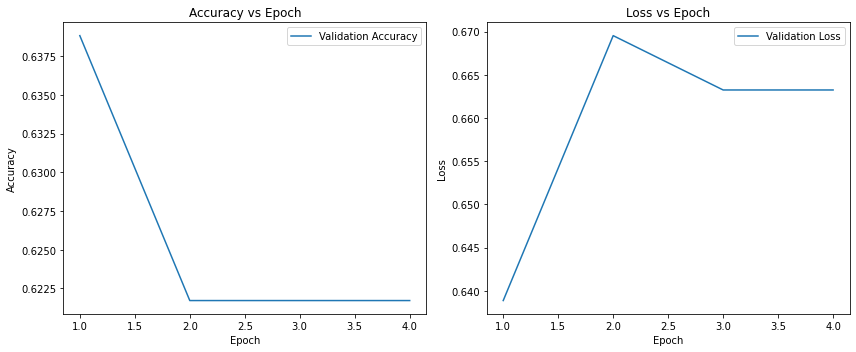

In [ ]:
epochs = range(1, len(metric_logger.eval_accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, metric_logger.eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, metric_logger.eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# results for mlp + 2 masks
results = {
    1.0: {'eval_accuracy': [0.6348, 0.6883, 0.7085, 0.7085],
          'eval_loss': [0.64, 0.61, 0.58, 0.58]},
    0.8: {'eval_accuracy': [0.6348, 0.6795, 0.7146, 0.7146],
          'eval_loss': [0.64, 0.60, 0.56, 0.56]},
    0.6: {'eval_accuracy': [0.6348, 0.6217, 0.7082, 0.7082],
          'eval_loss': [0.64, 0.65, 0.57, 0.57]},
    0.4: {'eval_accuracy': [0.6348, 0.6217, 0.6217, 0.6217],
          'eval_loss': [0.64, 0.665, 0.661, 0.61]},
    0.2: {'eval_accuracy': [0.6348, 0.6217, 0.6217, 0.6217],
          'eval_loss': [0.64, 0.668, 0.664, 0.664]},
}


In [ ]:
# results for mlp + 1 mask
results_1 = {
    1.0: {'eval_accuracy': [0.6388, 0.6816, 0.7058, 0.7058],
          'eval_loss': [0.64, 0.59, 0.60, 0.60]},
    0.8: {'eval_accuracy': [0.6388, 0.6608, 0.7119, 0.7119],
          'eval_loss': [0.64, 0.61, 0.59, 0.59]},
    0.6: {'eval_accuracy': [0.6388, 0.6590, 0.7009, 0.7009],
          'eval_loss': [0.64, 0.62, 0.58, 0.58]},
    0.4: {'eval_accuracy': [0.6388, 0.6217, 0.6217, 0.6217],
          'eval_loss': [0.64, 0.67, 0.655, 0.655]},
    0.2: {'eval_accuracy': [0.6388, 0.6217, 0.6217, 0.6217],
          'eval_loss': [0.64, 0.67, 0.663, 0.663]},
}

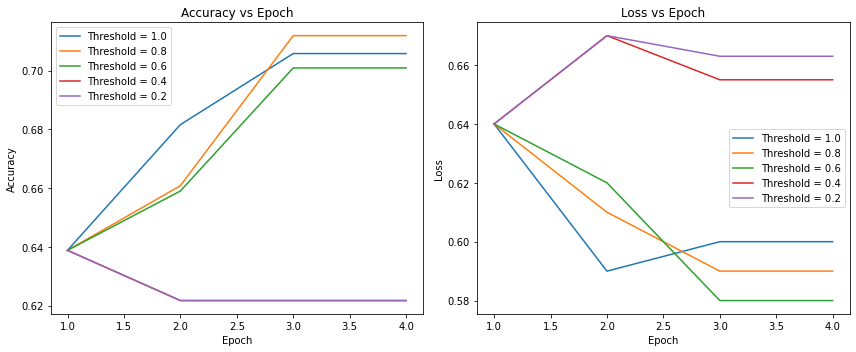

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(results_1):
    plt.figure(figsize=(12, 5))

    # Validation Accuracy
    plt.subplot(1, 2, 1)
    for threshold, metrics in results_1.items():
        epochs = range(1, len(metrics['eval_accuracy']) + 1)
        plt.plot(epochs, metrics['eval_accuracy'], label=f'Threshold = {threshold}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()

    # Validation Loss
    plt.subplot(1, 2, 2)
    for threshold, metrics in results_1.items():
        epochs = range(1, len(metrics['eval_loss']) + 1)
        plt.plot(epochs, metrics['eval_loss'], label=f'Threshold = {threshold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(results_1)
